In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/elliptic/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv


In [2]:
!pip install torch_geometric==2.5.0
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.9 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import TAGConv, GCNConv, SAGEConv, GATConv
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

base_path = "/kaggle/input/elliptic/elliptic_bitcoin_dataset/"

In [4]:
# 数据加载 
df_classes = pd.read_csv(base_path + 'elliptic_txs_classes.csv')
df_edges = pd.read_csv(base_path + 'elliptic_txs_edgelist.csv')
df_features = pd.read_csv(base_path + 'elliptic_txs_features.csv', header=None)

# 删除 unknown 类别，仅保留合法/非法交易（1/2）
df_classes = df_classes[df_classes['class'] != 'unknown']
df_classes['class'] = df_classes['class'].map({'1': 1, '2': 0})  # 1: illicit, 0: licit

# 合并特征与标签
df_merge = df_features.merge(df_classes, how='inner', right_on="txId", left_on=0)
df_merge = df_merge.drop(['txId'], axis=1)

nodes = df_merge[0].values
map_id = {j: i for i, j in enumerate(nodes)}

edges = df_edges[df_edges.txId1.isin(map_id) & df_edges.txId2.isin(map_id)].copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = torch.tensor(np.array(edges.values).T, dtype=torch.long)
weights = torch.tensor([1] * edge_index.shape[1], dtype=torch.float32)

labels = torch.tensor(df_merge['class'].values, dtype=torch.float32)
node_features = torch.tensor(np.array(df_merge.drop([0, 'class', 1], axis=1).values), dtype=torch.float32)

elliptic_dataset = Data(x=node_features, edge_index=edge_index, edge_weights=weights, y=labels)

In [5]:
# ====================== 数据划分 ======================
seed = 0
torch.manual_seed(seed)

all_idx = np.arange(len(labels))
y_all = labels[all_idx]
train_idx, temp_idx = train_test_split(all_idx, test_size=0.3, random_state=seed, stratify=y_all)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=seed, stratify=labels[temp_idx])

elliptic_dataset.train_idx = torch.tensor(train_idx)
elliptic_dataset.val_idx = torch.tensor(val_idx)
elliptic_dataset.test_idx = torch.tensor(test_idx)

In [6]:
# 模型定义
class TAGCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, K=3):
        super().__init__()
        self.norm1 = torch.nn.BatchNorm1d(dim_in)
        self.conv1 = TAGConv(dim_in, dim_h, K)
        self.norm2 = torch.nn.BatchNorm1d(dim_h)
        self.conv2 = TAGConv(dim_h, dim_out, K)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.conv1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out = self.conv2(h, edge_index)
        return out


class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, dim_h)
        self.conv2 = GCNConv(dim_h, dim_out)
        self.bn = torch.nn.BatchNorm1d(dim_h)

    def forward(self, x, edge_index):
        h = F.relu(self.bn(self.conv1(x, edge_index)))
        out = self.conv2(h, edge_index)
        return out


class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.conv1 = SAGEConv(dim_in, dim_h)
        self.conv2 = SAGEConv(dim_h, dim_out)
        self.bn = torch.nn.BatchNorm1d(dim_h)

    def forward(self, x, edge_index):
        h = F.relu(self.bn(self.conv1(x, edge_index)))
        out = self.conv2(h, edge_index)
        return out


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.3)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [7]:
# 训练与评估函数
def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()
    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc


def train(model, data, criterion, optimizer, num_epochs, save_path):
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index)
        loss = criterion(pred[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_loss = criterion(pred[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
    return


# ====================== 训练四个模型 ======================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = node_features.shape[1]
hidden_dim = 150
output_dim = 1
num_epochs = 200
lr = 0.005
weight_decay = 1e-5

models = {
    'GCN': GCN(input_dim, hidden_dim, output_dim).to(device),
    'GraphSAGE': GraphSAGE(input_dim, hidden_dim, output_dim).to(device),
    "GAT": GAT(input_dim, hidden_dim, output_dim).to(device),
    'TAGCN': TAGCN(input_dim, hidden_dim, output_dim).to(device)
}

criterion = torch.nn.BCEWithLogitsLoss()

os.makedirs('./result/models', exist_ok=True)

for name, model in models.items():
    print(f"Training {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train(model, elliptic_dataset.to(device), criterion, optimizer, num_epochs, f'./result/models/{name}_best.pth.tar')

Training GCN...
Training GraphSAGE...
Training GAT...
Training TAGCN...


In [8]:
# 可解释性对比分析
def make_predict_fn(model, data, node_idx):
    def predict_fn(x_numpy_batch):
        model.eval()
        x_clone = data.x.clone().to(device)
        outputs = []
        with torch.no_grad():
            for i in range(x_numpy_batch.shape[0]):
                x_clone[node_idx] = torch.tensor(x_numpy_batch[i], dtype=torch.float32, device=device)
                out = model(x_clone, data.edge_index)
                prob = torch.sigmoid(out[node_idx])
                outputs.append(prob.cpu().numpy())
        return np.array(outputs)
    return predict_fn


def shap_concentration(shap_values):
    vals = np.abs(shap_values.values).flatten()
    top_k = np.sort(vals)[-10:]
    return np.sum(top_k) / np.sum(vals)

In [9]:
# 可解释性对比分析
def make_predict_fn(model, data, node_idx):
    def predict_fn(x_numpy_batch):
        model.eval()
        x_clone = data.x.clone().to(device)
        outputs = []
        with torch.no_grad():
            for i in range(x_numpy_batch.shape[0]):
                x_clone[node_idx] = torch.tensor(x_numpy_batch[i], dtype=torch.float32, device=device)
                out = model(x_clone, data.edge_index)
                prob = torch.sigmoid(out[node_idx])
                outputs.append(prob.cpu().numpy())
        return np.array(outputs)
    return predict_fn


def shap_concentration(shap_values):
    vals = np.abs(shap_values.values).flatten()
    top_k = np.sort(vals)[-10:]
    return np.sum(top_k) / np.sum(vals)

In [10]:
# 多节点平均解释对比

# 取若干非法节点作为评估样本
illicit_indices = (elliptic_dataset.y == 1).nonzero(as_tuple=True)[0].cpu().numpy()
np.random.seed(42)
sample_nodes = np.random.choice(illicit_indices, size=10, replace=False)

masker = shap.maskers.Independent(elliptic_dataset.x.cpu().numpy())

concentrations = {}

for name, model in models.items():
    print(f"Evaluating interpretability for {name}...")
    model.load_state_dict(torch.load(f'./result/models/{name}_best.pth.tar', map_location=device))
    model.to(device)

    conc_list, stab_list = [], []

    for node_idx in sample_nodes:
        node_feat = elliptic_dataset.x[node_idx].cpu().numpy().reshape(1, -1)
        explainer = shap.Explainer(make_predict_fn(model, elliptic_dataset.to(device), node_idx), masker)
        shap_values = explainer(node_feat)

        # 计算集中度
        conc = shap_concentration(shap_values)
        conc_list.append(conc)

    concentrations[name] = np.mean(conc_list)

    print(f"{name} Mean SHAP Concentration: {concentrations[name]:.3f}")
    print("-" * 60)

Evaluating interpretability for GCN...


PermutationExplainer explainer: 2it [01:14, 74.61s/it]               
PermutationExplainer explainer: 2it [01:10, 70.89s/it]               
PermutationExplainer explainer: 2it [01:21, 81.14s/it]               
PermutationExplainer explainer: 2it [01:12, 72.76s/it]               
PermutationExplainer explainer: 2it [01:10, 70.16s/it]               
PermutationExplainer explainer: 2it [01:08, 68.36s/it]               
PermutationExplainer explainer: 2it [01:12, 72.51s/it]               
PermutationExplainer explainer: 2it [01:10, 70.46s/it]               
PermutationExplainer explainer: 2it [01:10, 70.56s/it]               
PermutationExplainer explainer: 2it [01:13, 73.64s/it]               


GCN Mean SHAP Concentration: 0.388
------------------------------------------------------------
Evaluating interpretability for GraphSAGE...


PermutationExplainer explainer: 2it [01:12, 72.21s/it]               
PermutationExplainer explainer: 2it [01:11, 71.90s/it]               
PermutationExplainer explainer: 2it [01:22, 82.40s/it]               
PermutationExplainer explainer: 2it [01:13, 73.72s/it]               
PermutationExplainer explainer: 2it [01:11, 71.38s/it]               
PermutationExplainer explainer: 2it [01:09, 69.65s/it]               
PermutationExplainer explainer: 2it [01:13, 73.73s/it]               
PermutationExplainer explainer: 2it [01:11, 71.81s/it]               
PermutationExplainer explainer: 2it [01:11, 71.74s/it]               
PermutationExplainer explainer: 2it [01:14, 74.78s/it]               


GraphSAGE Mean SHAP Concentration: 0.494
------------------------------------------------------------
Evaluating interpretability for GAT...


PermutationExplainer explainer: 2it [03:39, 219.33s/it]              
PermutationExplainer explainer: 2it [03:38, 218.88s/it]              
PermutationExplainer explainer: 2it [04:10, 250.84s/it]              
PermutationExplainer explainer: 2it [03:44, 224.21s/it]              
PermutationExplainer explainer: 2it [03:37, 217.34s/it]              
PermutationExplainer explainer: 2it [03:32, 212.13s/it]              
PermutationExplainer explainer: 2it [03:44, 224.64s/it]              
PermutationExplainer explainer: 2it [03:38, 218.20s/it]              
PermutationExplainer explainer: 2it [03:38, 218.56s/it]              
PermutationExplainer explainer: 2it [03:47, 227.39s/it]              


GAT Mean SHAP Concentration: 0.452
------------------------------------------------------------
Evaluating interpretability for TAGCN...


PermutationExplainer explainer: 2it [02:45, 165.14s/it]              
PermutationExplainer explainer: 2it [02:44, 164.94s/it]              
PermutationExplainer explainer: 2it [03:09, 189.04s/it]              
PermutationExplainer explainer: 2it [02:49, 169.03s/it]              
PermutationExplainer explainer: 2it [02:43, 163.95s/it]              
PermutationExplainer explainer: 2it [02:40, 160.00s/it]              
PermutationExplainer explainer: 2it [02:49, 169.28s/it]              
PermutationExplainer explainer: 2it [02:44, 164.38s/it]              
PermutationExplainer explainer: 2it [02:44, 164.77s/it]              
PermutationExplainer explainer: 2it [02:51, 171.66s/it]              

TAGCN Mean SHAP Concentration: 0.533
------------------------------------------------------------


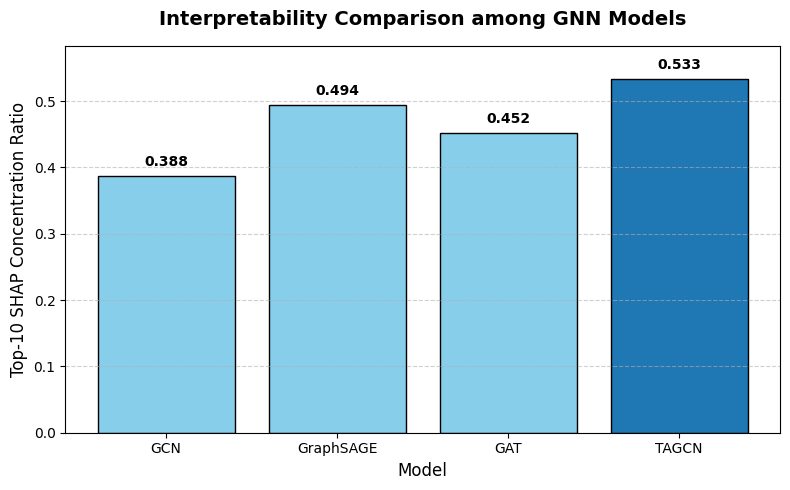

In [11]:
import matplotlib.pyplot as plt

# 绘制 SHAP 集中度对比图
plt.figure(figsize=(8, 5))

models_list = list(concentrations.keys())
values_list = list(concentrations.values())

colors = ['skyblue', 'skyblue', 'skyblue', '#1f77b4']  # TAGCN高亮

bars = plt.bar(models_list, values_list, color=colors, edgecolor='black')

# 在每个柱子上显示具体数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Interpretability Comparison among GNN Models", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("Top-10 SHAP Concentration Ratio", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, max(values_list) + 0.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("./result/shap_concentration_comparison.png", dpi=600)
plt.show()